In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/SDG/project/sdg-codebase/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SDG/project/sdg-codebase


# Loading data

In [ ]:
import pandas as pd
!pip install transformers
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from transformers import AdamW
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
def read_data():
  return pd.read_csv("data/SDG_newRainmaking_others.csv")

data = read_data()
data.shape

(2729, 15)

In [ ]:
data.head()

,Unnamed: 0,Company,Website,Source,Description,Location,SDG Goal,five Ps,Rainmaking SDG Subtopic,Impact Statement,Location of Impact,Primary SDG,Additional SDGs,sub target,_merge
0,0,10Power,http://10pwr.com/,Rainmaking,10Power provides project development and finan...,USA,7.0,Prosperity,7.1 Energy Access Solutions,To provide project development and finance for...,United States of America,SDG 7: Affordable and Clean Energy,NaN,NaN,NaN
1,1,1Efficiency,1efficiency.com,Rainmaking,1Efficiency offers an integrated suite of cust...,USA,7.0,Prosperity,7.4 Energy Enablers,Energy management suite,United States of America,SDG 7: Affordable and Clean Energy,NaN,NaN,NaN
2,3,24SEA,24sea.eu,Rainmaking,24SEA provides a suite of solutions for monito...,Belgium,7.0,Prosperity,7.1 Energy Access Solutions,Offshore monitoring and engineering service pr...,Belgium,SDG 7: Affordable and Clean Energy,NaN,NaN,NaN
3,6,4NEW,https://4new.io/,Rainmaking,"The world's first eco-friendly, tangible Waste...",United Kingdom,7.0,Prosperity,7.4 Energy Enablers,NaN,UK,SDG 7: Affordable and Clean Energy,NaN,NaN,NaN
4,8,3oun,http://3oun.com/,Rainmaking,3oun is a platform for home maintenance servic...,NaN,8.0,Prosperity,NaN,Aoun is a home maintenance mobile application ...,NaN,SDG 8: Decent Work and Economic Growth,NaN,NaN,NaN


In [ ]:
data['SDG Goal'].value_counts()

7.0     719
2.0     375
3.0     259
12.0    235
1.0     222
9.0     167
13.0    142
4.0     102
8.0      85
16.0     78
11.0     64
6.0      58
14.0     55
10.0     51
5.0      46
15.0     36
17.0     35
Name: SDG Goal, dtype: int64

In [ ]:
data['five Ps'].value_counts()

Prosperity      1321
People          1062
Planet           233
Peace             78
Partnerships      35
Name: five Ps, dtype: int64

In [ ]:
data['Location'].str.lower().value_counts()[:50]

usa               471
sweden            247
denmark           209
united kingdom    137
norway            131
india             126
finland            96
netherlands        72
france             64
københavn          57
germany            53
kenya              48
spain              40
canada             36
chile              33
argentina          33
switzerland        32
australia          31
israel             30
helsinki           30
south africa       29
austria            26
mexico             24
china              20
singapore          19
nigeria            16
italy              16
ireland            16
ghana              15
brazil             13
helsingfors        13
oslo               12
peru               12
colombia           12
belgium            10
indonesia           8
espoo               8
stockholm           8
uganda              8
thailand            7
nepal               6
philippines         6
oulu                6
frederiksberg       6
guatemala           6
copenhagen

# plot metrics

In [ ]:
def plotAccPrecRecall(y_test, y_pred, predicted_prob, verbose=False):
  accuracy = metrics.accuracy_score(y_test, y_pred)
  auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
  print("Accuracy:",  round(accuracy,2))
  if verbose:
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, y_pred))

  return accuracy

In [ ]:
def plotConfusionMatrix(y_test, y_pred, labels):
  cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=labels, 
        yticklabels=labels, title="Confusion matrix")
  plt.yticks(rotation=0)

In [ ]:
def plotRocPrecRecallCurve(y_test, predicted_prob, labels):
  y_test_array = pd.get_dummies(y_test, drop_first=False).values
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
  ## Plot roc
  for i in range(len(labels)):
      fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
      ax[0].plot(fpr, tpr, lw=3,
                label='{0} (area={1:0.2f})'.format(labels[i], 
                                metrics.auc(fpr, tpr),)
                )
  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='False Positive Rate', 
            ylabel="True Positive Rate (Recall)", 
            title="Receiver operating characteristic")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)
      
  ## Plot precision-recall curve
  for i in range(len(labels)):
      precision, recall, thresholds = metrics.precision_recall_curve(
                  y_test_array[:,i], predicted_prob[:,i])
      ax[1].plot(recall, precision, lw=3, 
                label='{0} (area={1:0.2f})'.format(labels[i], 
                                    metrics.auc(recall, precision))
                )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)
  plt.show()

In [ ]:
def SDGToFivePs(x):
  x = int(x.replace("_goal",""))
  if x in range(0,7):
    return 'People'
  if x in range(13,16):
    return 'Planet'
  if x in range(7,13):
    return 'Prosperity'
  if x in range(16,17):
    return 'Peace'
  if x in range(17,18):
    return 'Partnerships'
  return None

# Model

In [ ]:
class SDGModel(torch.nn.Module):
  def __init__(self, output_size):
    super(SDGModel, self).__init__()
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.bert = BertModel.from_pretrained('bert-base-uncased')
#     for index, param in enumerate(self.bert.parameters()):
#         print(index, param.shape)
#         param.requires_grad = False
    self.out1 = torch.nn.Linear(768, 400)
    self.drop = torch.nn.Dropout(0.5)
    self.out2 = torch.nn.Linear(400, output_size)

  def forward(self, text):
    tokenized_text = self.tokenizer.tokenize("[CLS] " + text + " [SEP]")
    indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens]).cuda()
    
    if tokens_tensor.shape[1] > 500:
      tokens_tensor = tokens_tensor[0][0:500].unsqueeze(0)
    outputs = self.bert(tokens_tensor)[0]
    o = torch.nn.ReLU()(self.out1(outputs[0][0]))
    o = self.drop(o)
    return self.out2(o)


In [ ]:
from sklearn import metrics
import seaborn as sns
import numpy as np

def evaluate_mode(X_test, model, verbose=True):

  model.eval()
  errors = []
  softmax = torch.nn.Softmax(dim=0)

  #eval
  with torch.no_grad():
      y_pred = []
      predicted_prob = []
      y_test = X_test["Target"]
      for index, instance in X_test.iterrows():
          out = model(instance["Description"].lower())
          predicted_prob.append(softmax(out).tolist())
          y_pred.append(labels[torch.argmax(out).item()])
          # collect companies with errors
          if instance['Target'] != labels[torch.argmax(out).item()]:
            errors.append((instance['Company'], instance['Target'], labels[torch.argmax(out).item()]))
      model.train()

  predicted_prob = np.array(predicted_prob)

  ## plot Accuracy, Precision, Recall
  accuracy = plotAccPrecRecall(y_test, y_pred, predicted_prob, verbose)
      
  ## Plot confusion matrix
  plotConfusionMatrix(y_test, y_pred, labels)

  ## Plot roc, precision recall curve
  if verbose:
    plotRocPrecRecallCurve(y_test, predicted_prob, labels)

  return errors, accuracy

# All Goals

## Predict five Ps

In [ ]:
data = read_data()
data = data[data['Description'].isnull() == False]
data.shape

(2729, 15)

In [ ]:
data['Target'] = data['five Ps']
labels = list(data['Target'].value_counts().keys().values)
X_train, X_test, y_train, y_test = train_test_split(data, data["Target"], test_size=0.15, random_state=42)
print(labels)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.index[0:5])

['Prosperity', 'People', 'Planet', 'Peace', 'Partnerships']
2319 2319
410 410
Int64Index([2175, 1075, 929, 2189, 679], dtype='int64')


In [ ]:
X_train['Target'].value_counts()

Prosperity      1118
People           901
Planet           200
Peace             68
Partnerships      32
Name: Target, dtype: int64

In [ ]:
X_test['Target'].value_counts()

Prosperity      203
People          161
Planet           33
Peace            10
Partnerships      3
Name: Target, dtype: int64

In [ ]:
# # new model configuration

# model = SDGModel(len(labels)).cuda()
# optimizer = AdamW(model.parameters(), lr=1e-5)
# losses = []
# errors = []
# epoch = 1
# accuracies = []

# model("Hello World")

tensor([-0.1429,  0.0677, -0.3656, -0.2295,  0.4750], device='cuda:0',
       grad_fn=<AddBackward0>)

In [ ]:
# load model from checkpoint

device = torch.device("cuda")
model = SDGModel(len(labels))
optimizer = AdamW(model.parameters(), lr=1e-5)

checkpoint = torch.load(f"models/model_5Ps_allrain_checkpoint_7.tar")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
losses = checkpoint['losses']
errors = checkpoint['errors']
accuracies = checkpoint['accuracies']

# model.eval()
# - or -
model.train()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

#### first cycle

2319
Epoch=1, index=1020, loss=1.0017448703447978, counter=19
Prosperity --> Prosperity
Epoch=1, index=2490, loss=0.7551006734371185, counter=37
Prosperity --> Prosperity
Epoch=1, index=120, loss=1.861925216515859, counter=81
People --> Prosperity
Epoch=1, index=1470, loss=1.2511496762434642, counter=116
Prosperity --> People
Epoch=1, index=0, loss=0.35140187044938404, counter=126
Prosperity --> Prosperity
Epoch=1, index=2430, loss=0.5074019819498062, counter=138
Prosperity --> Prosperity
Epoch=1, index=1230, loss=0.07873331705729167, counter=140
People --> Prosperity
Epoch=1, index=2370, loss=2.053702292839686, counter=196
Prosperity --> Prosperity
Epoch=1, index=1320, loss=0.4320688505967458, counter=209
Prosperity --> People
Epoch=1, index=930, loss=0.1912486712137858, counter=216
People --> Prosperity
Epoch=1, index=2280, loss=1.3558317770560582, counter=262
People --> People
Epoch=1, index=1710, loss=0.49367395689090093, counter=285
People --> People
Epoch=1, index=2040, loss=2.15

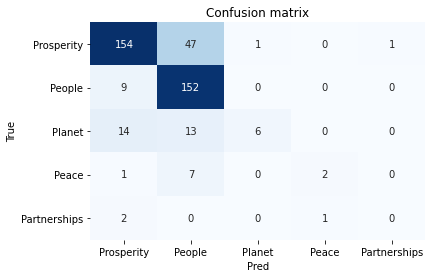

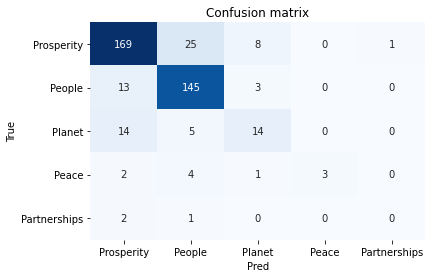

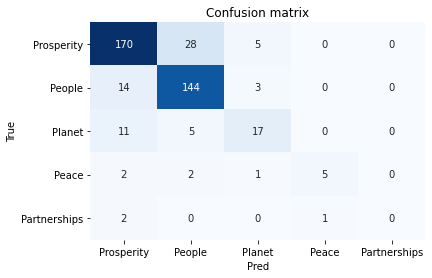

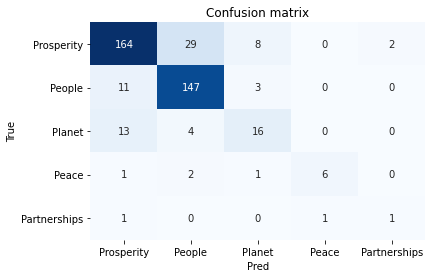

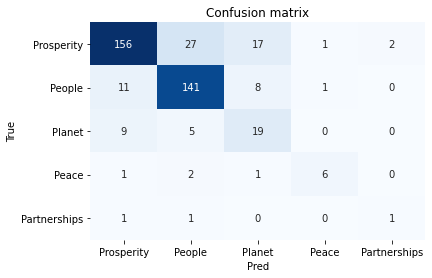

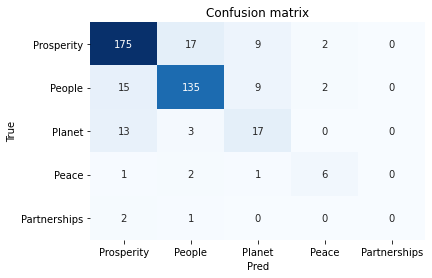

In [ ]:
import time

n_epochs = 6

start_time = time.time()

for e in range(epoch, epoch+n_epochs):
  cnt = 0
  current_loss = 0
  epoc_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    cnt += 1
    optimizer.zero_grad()
    out = model(instance["Description"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    epoc_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}, counter={cnt}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error, acc = evaluate_mode(X_test, model, False)
  print(error[0][:5])
  print(f"total loss={epoc_loss/len(curr_data)}")
  losses.append(epoc_loss/len(curr_data))
  errors.append(error)
  accuracies.append(acc)
  print(f"TIME TILL NOW: avg={(time.time() - start_time)/60/e:.1f}, for {e} epochs - {(time.time() - start_time)/60:.1f} min")

Accuracy: 0.81
Auc: 0.47
Detail:
              precision    recall  f1-score   support

Partnerships       0.00      0.00      0.00         3
       Peace       0.60      0.60      0.60        10
      People       0.85      0.84      0.85       161
      Planet       0.47      0.52      0.49        33
  Prosperity       0.85      0.86      0.86       203

    accuracy                           0.81       410
   macro avg       0.56      0.56      0.56       410
weighted avg       0.81      0.81      0.81       410



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


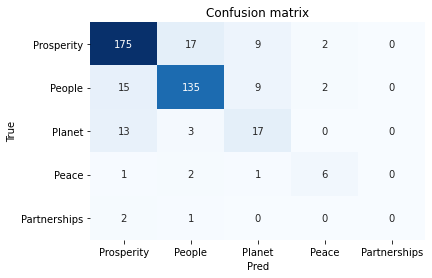

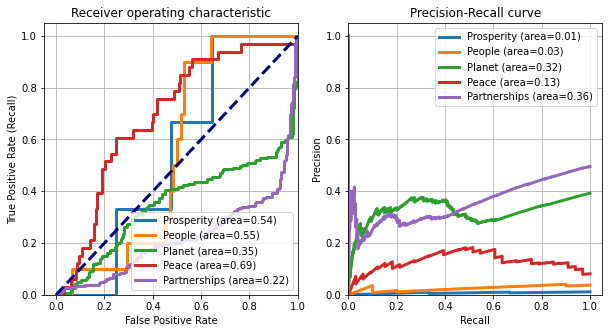

In [ ]:
errors, acc = evaluate_mode(X_test, model)

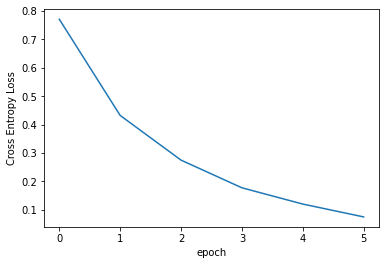

In [ ]:
## Plot loss for epoc

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(epoch+n_epochs-1), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
losses

[tensor(0.7704, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4321, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2749, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1776, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1204, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0752, device='cuda:0', grad_fn=<DivBackward0>)]

In [ ]:
# errors

In [ ]:
print(f"avg - {sum(accuracies[-10:])/len(accuracies[-10:])}")
accuracies

avg - 0.801219512195122


[0.7658536585365854,
 0.8073170731707318,
 0.8195121951219512,
 0.8146341463414634,
 0.7878048780487805,
 0.8121951219512196]

In [ ]:
# save model configuration for latter training

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch+n_epochs,
    'losses': losses,
    'errors': errors,
    'accuracies': accuracies
}

torch.save(checkpoint, f"models/model_5Ps_allrain_checkpoint_{checkpoint['epoch']}.tar")

#### second cycle

2319
Epoch=7, index=1740, loss=0.0027044465862369788, counter=21
People --> People
Epoch=7, index=630, loss=5.8904864514867467e-05, counter=22
Prosperity --> Prosperity
Epoch=7, index=600, loss=0.01890222552853326, counter=76
Partnerships --> Partnerships
Epoch=7, index=720, loss=0.00019492673454806208, counter=79
People --> People
Epoch=7, index=750, loss=0.009929276901918154, counter=88
Prosperity --> Prosperity
Epoch=7, index=1650, loss=0.10907724248827436, counter=119
People --> People
Epoch=7, index=2280, loss=0.13548615108399342, counter=130
People --> People
Epoch=7, index=1050, loss=0.0001885656383819878, counter=132
People --> People
Epoch=7, index=360, loss=0.024603108565012615, counter=158
Prosperity --> Prosperity
Epoch=7, index=2040, loss=0.06214665683025184, counter=221
Prosperity --> Prosperity
Epoch=7, index=60, loss=6.0641649179160594e-05, counter=223
Prosperity --> Prosperity
Epoch=7, index=1620, loss=0.0036323652525121967, counter=227
Peace --> Peace
Epoch=7, index=1

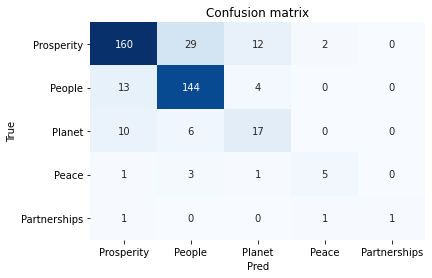

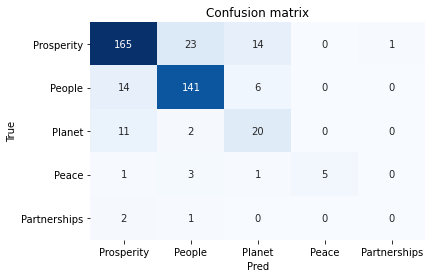

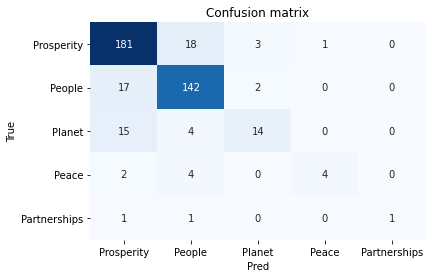

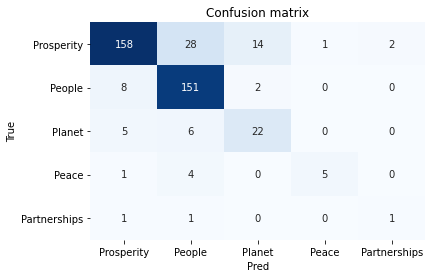

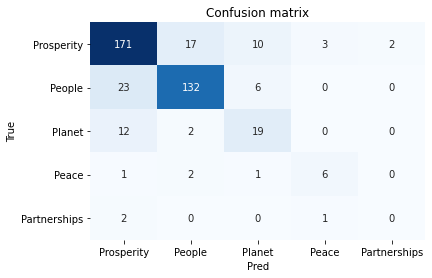

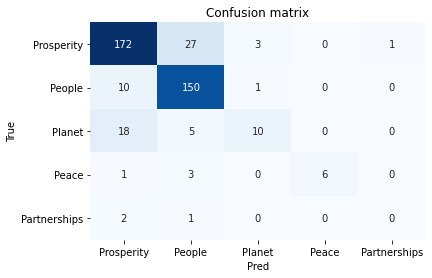

In [ ]:
import time

n_epochs = 6

start_time = time.time()

for e in range(epoch, epoch+n_epochs):
  cnt = 0
  current_loss = 0
  epoc_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    cnt += 1
    optimizer.zero_grad()
    out = model(instance["Description"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    epoc_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}, counter={cnt}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error, acc = evaluate_mode(X_test, model, False)
  print(error[0][:5])
  print(f"total loss={epoc_loss/len(curr_data)}")
  losses.append(epoc_loss/len(curr_data))
  errors.append(error)
  accuracies.append(acc)
  print(f"TIME TILL NOW: avg={(time.time() - start_time)/60/e:.1f}, for {e} epochs - {(time.time() - start_time)/60:.1f} min")

Accuracy: 0.82
Auc: 0.55
Detail:
              precision    recall  f1-score   support

Partnerships       0.00      0.00      0.00         3
       Peace       1.00      0.60      0.75        10
      People       0.81      0.93      0.86       161
      Planet       0.71      0.30      0.43        33
  Prosperity       0.85      0.85      0.85       203

    accuracy                           0.82       410
   macro avg       0.67      0.54      0.58       410
weighted avg       0.82      0.82      0.81       410



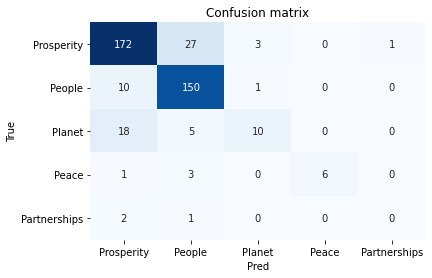

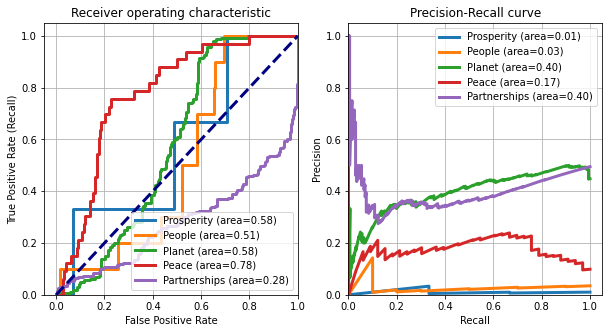

In [ ]:
errors, acc = evaluate_mode(X_test, model)

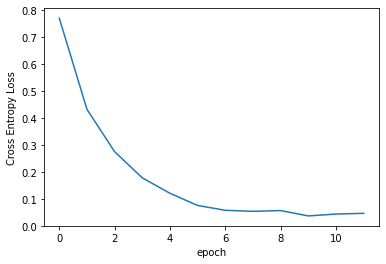

In [ ]:
## Plot loss for epoc

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(epoch+n_epochs-1), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
losses

[tensor(0.7704, device='cuda:0', requires_grad=True),
 tensor(0.4321, device='cuda:0', requires_grad=True),
 tensor(0.2749, device='cuda:0', requires_grad=True),
 tensor(0.1776, device='cuda:0', requires_grad=True),
 tensor(0.1204, device='cuda:0', requires_grad=True),
 tensor(0.0752, device='cuda:0', requires_grad=True),
 tensor(0.0573, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0534, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0562, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0364, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0433, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0460, device='cuda:0', grad_fn=<DivBackward0>)]

In [ ]:
# errors

In [ ]:
print(f"avg - {sum(accuracies[-10:])/len(accuracies[-10:])}")
accuracies

avg - 0.8119512195121953


[0.7658536585365854,
 0.8073170731707318,
 0.8195121951219512,
 0.8146341463414634,
 0.7878048780487805,
 0.8121951219512196,
 0.7975609756097561,
 0.8073170731707318,
 0.8341463414634146,
 0.8219512195121951,
 0.8,
 0.824390243902439]

In [ ]:
# save model configuration for latter training

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch+n_epochs,
    'losses': losses,
    'errors': errors,
    'accuracies': accuracies
}

torch.save(checkpoint, f"models/model_5Ps_allrain_checkpoint_{checkpoint['epoch']}.tar")

## Predict all goals

In [ ]:
data = read_data()
data = data[data['Description'].isnull() == False]
data.shape

(2729, 15)

In [ ]:
data['Target'] = data['SDG Goal'].astype(int)
labels = list(data['Target'].value_counts().keys().values)
X_train, X_test, y_train, y_test = train_test_split(data, data["Target"], test_size=0.15, random_state=42)
print(labels)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.index[0:5])

[7, 2, 3, 12, 1, 9, 13, 4, 8, 16, 11, 6, 14, 10, 5, 15, 17]
2319 2319
410 410
Int64Index([2175, 1075, 929, 2189, 679], dtype='int64')


In [ ]:
X_train['Target'].value_counts()

7     605
2     321
3     211
12    207
1     193
9     141
13    122
4      88
8      76
16     68
14     50
11     48
6      47
5      41
10     41
17     32
15     28
Name: Target, dtype: int64

In [ ]:
X_test['Target'].value_counts()

7     114
2      54
3      48
1      29
12     28
9      26
13     20
11     16
4      14
6      11
10     10
16     10
8       9
15      8
5       5
14      5
17      3
Name: Target, dtype: int64

In [ ]:
# # new model configuration

# model = SDGModel(len(labels)).cuda()
# optimizer = AdamW(model.parameters(), lr=1e-5)
# losses = []
# errors = []
# epoch = 1
# accuracies = []

# model("Hello World")

tensor([-0.0600,  0.1673, -0.2596,  0.3365, -0.0411, -0.0479, -0.3349,  0.0455,
        -0.4258, -0.0288,  0.0735, -0.2609,  0.3068,  0.0021, -0.1363, -0.0072,
        -0.0505], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
# load model from checkpoint

device = torch.device("cuda")
model = SDGModel(len(labels))
optimizer = AdamW(model.parameters(), lr=1e-5)

checkpoint = torch.load(f"models/model_SDG_allrain_checkpoint_7.tar")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
losses = checkpoint['losses']
errors = checkpoint['errors']
accuracies = checkpoint['accuracies']

# model.eval()
# - or -
model.train()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

#### first cycle

2319
Epoch=1, index=1710, loss=0.4851038376490275, counter=5
2.0 --> 12.0
Epoch=1, index=570, loss=0.7473396937052409, counter=13
3.0 --> 2.0
Epoch=1, index=2160, loss=1.825885502497355, counter=33
7.0 --> 12.0
Epoch=1, index=1620, loss=0.522046955426534, counter=38
16.0 --> 12.0
Epoch=1, index=720, loss=2.8730647643407186, counter=68
3.0 --> 2.0
Epoch=1, index=1230, loss=4.652936561902364, counter=122
1.0 --> 12.0
Epoch=1, index=2280, loss=0.1635849634806315, counter=124
1.0 --> 7.0
Epoch=1, index=240, loss=4.563776890436809, counter=178
7.0 --> 7.0
Epoch=1, index=2520, loss=0.9676447828610738, counter=190
7.0 --> 7.0
Epoch=1, index=990, loss=0.621865161259969, counter=197
4.0 --> 7.0
Epoch=1, index=300, loss=0.4507113138834635, counter=205
7.0 --> 7.0
Epoch=1, index=330, loss=7.420275960365931, counter=297
15.0 --> 7.0
Epoch=1, index=2700, loss=4.846490287780762, counter=368
12.0 --> 2.0
Epoch=1, index=660, loss=6.123485481739044, counter=452
11.0 --> 12.0
Epoch=1, index=2460, loss=0

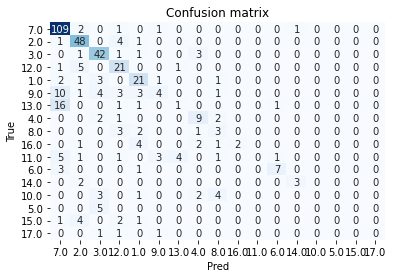

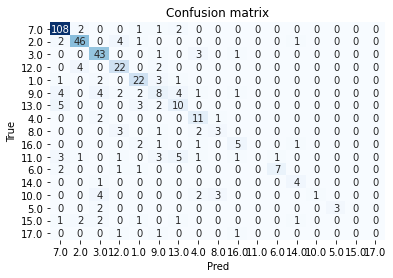

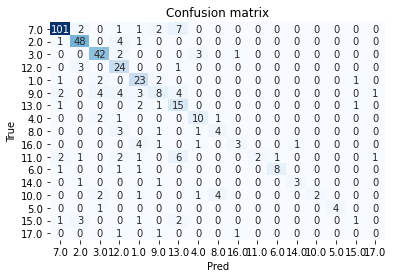

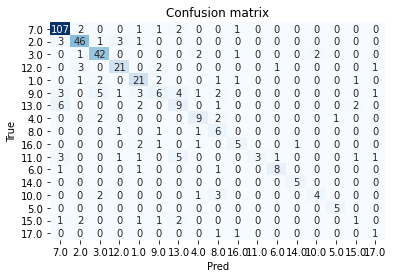

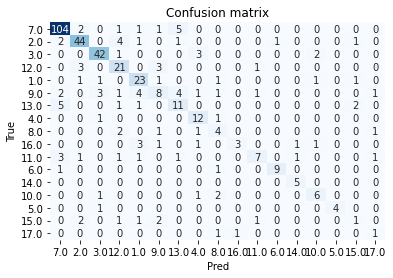

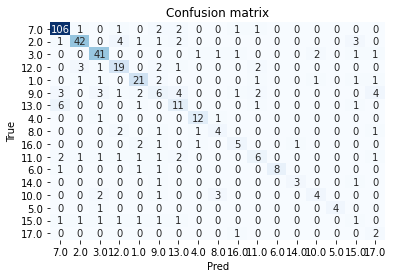

In [ ]:
import time

n_epochs = 6

start_time = time.time()

for e in range(epoch, epoch+n_epochs):
  cnt = 0
  current_loss = 0
  epoc_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    cnt += 1
    optimizer.zero_grad()
    out = model(instance["Description"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    epoc_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}, counter={cnt}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error, acc = evaluate_mode(X_test, model, False)
  print(error[0][:5])
  print(f"total loss={epoc_loss/len(curr_data)}")
  losses.append(epoc_loss/len(curr_data))
  errors.append(error)
  accuracies.append(acc)
  print(f"TIME TILL NOW: avg={(time.time() - start_time)/60/e:.1f}, for {e} epochs - {(time.time() - start_time)/60:.1f} min")

Accuracy: 0.72
Auc: 0.69
Detail:
              precision    recall  f1-score   support

           1       0.70      0.72      0.71        29
           2       0.86      0.78      0.82        54
           3       0.79      0.85      0.82        48
           4       0.80      0.86      0.83        14
           5       1.00      0.80      0.89         5
           6       1.00      0.73      0.84        11
           7       0.88      0.93      0.91       114
           8       0.44      0.44      0.44         9
           9       0.30      0.23      0.26        26
          10       0.57      0.40      0.47        10
          11       0.46      0.38      0.41        16
          12       0.66      0.68      0.67        28
          13       0.48      0.55      0.51        20
          14       0.75      0.60      0.67         5
          15       0.12      0.12      0.12         8
          16       0.56      0.50      0.53        10
          17       0.20      0.67      0.31     

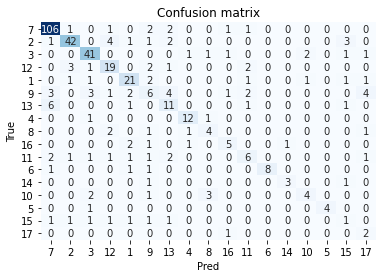

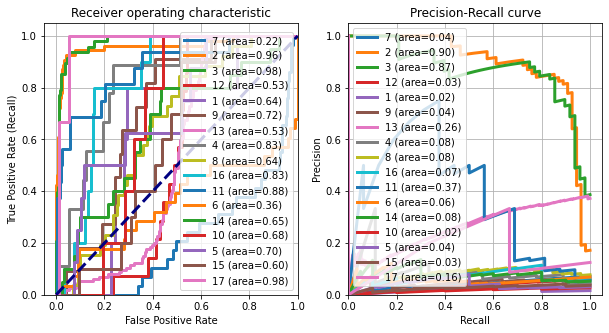

In [ ]:
errors, acc = evaluate_mode(X_test, model)

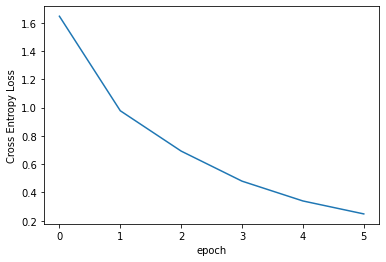

In [ ]:
## Plot loss for epoc

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(epoch+n_epochs-1), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
losses

[tensor(1.6467, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9780, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.6925, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4798, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3397, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2480, device='cuda:0', grad_fn=<DivBackward0>)]

In [ ]:
# errors

In [ ]:
print(f"avg - {sum(accuracies[-10:])/len(accuracies[-10:])}")
accuracies

avg - 0.7154471544715447


[0.6585365853658537,
 0.7146341463414634,
 0.7268292682926829,
 0.7292682926829268,
 0.7439024390243902,
 0.7195121951219512]

In [ ]:
# save model configuration for latter training

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch+n_epochs,
    'losses': losses,
    'errors': errors,
    'accuracies': accuracies
}

torch.save(checkpoint, f"models/model_SDG_allrain_checkpoint_{checkpoint['epoch']}.tar")

#### second cycle

2319
Epoch=7, index=1470, loss=0.12057464692431191, counter=15
7 --> 7
Epoch=7, index=540, loss=0.016849511380617816, counter=28
3 --> 3
Epoch=7, index=240, loss=0.3207570785967012, counter=70
7 --> 7
Epoch=7, index=90, loss=0.0011690701823681593, counter=73
7 --> 7
Epoch=7, index=2490, loss=0.7523017258150503, counter=167
9 --> 9
Epoch=7, index=1620, loss=0.06891409836243838, counter=181
16 --> 16
Epoch=7, index=990, loss=0.001103820155064265, counter=182
4 --> 4
Epoch=7, index=1740, loss=0.23347038560702155, counter=266
1 --> 1
Epoch=7, index=2550, loss=0.00884853806346655, counter=274
2 --> 2
Epoch=7, index=60, loss=0.36810603310198836, counter=318
7 --> 7
Epoch=7, index=1860, loss=0.017900857515633105, counter=324
13 --> 13
Epoch=7, index=2460, loss=0.1755946286333104, counter=331
7 --> 7
Epoch=7, index=750, loss=0.01624451590081056, counter=337
12 --> 12
Epoch=7, index=1020, loss=0.6475095013932636, counter=405
10 --> 3
Epoch=7, index=900, loss=0.04283675095066428, counter=413
3 -

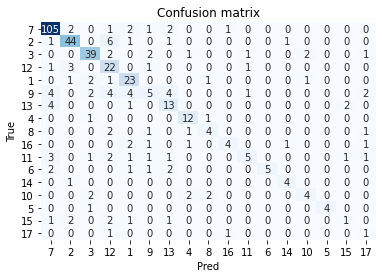

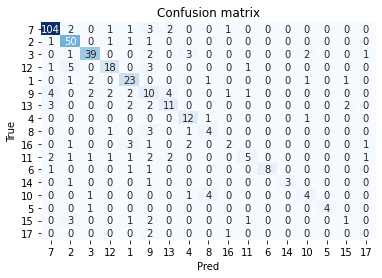

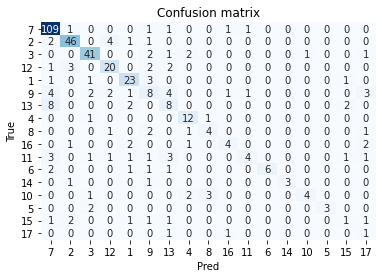

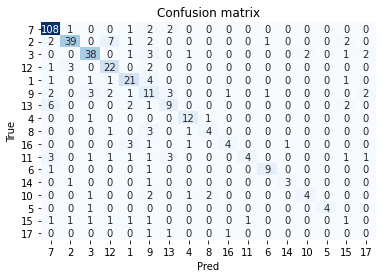

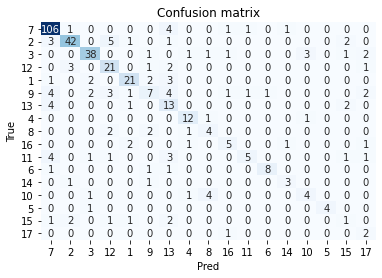

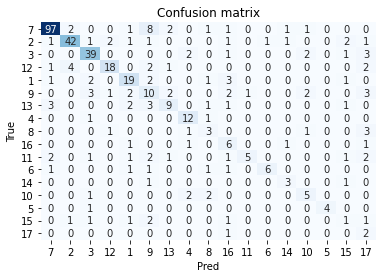

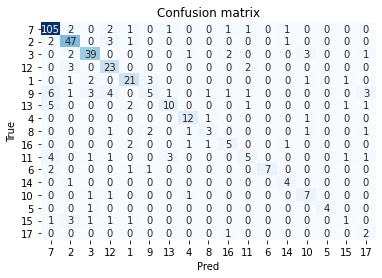

In [ ]:
import time

n_epochs = 7

start_time = time.time()

for e in range(epoch, epoch+n_epochs):
  cnt = 0
  current_loss = 0
  epoc_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    cnt += 1
    optimizer.zero_grad()
    out = model(instance["Description"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    epoc_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}, counter={cnt}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error, acc = evaluate_mode(X_test, model, False)
  print(error[0][:5])
  print(f"total loss={epoc_loss/len(curr_data)}")
  losses.append(epoc_loss/len(curr_data))
  errors.append(error)
  accuracies.append(acc)
  print(f"TIME TILL NOW: avg={(time.time() - start_time)/60/e:.1f}, for {e} epochs - {(time.time() - start_time)/60:.1f} min")

Accuracy: 0.73
Auc: 0.67
Detail:
              precision    recall  f1-score   support

           1       0.72      0.72      0.72        29
           2       0.78      0.87      0.82        54
           3       0.81      0.81      0.81        48
           4       0.75      0.86      0.80        14
           5       1.00      0.80      0.89         5
           6       1.00      0.64      0.78        11
           7       0.84      0.92      0.88       114
           8       0.50      0.33      0.40         9
           9       0.45      0.19      0.27        26
          10       0.54      0.70      0.61        10
          11       0.50      0.31      0.38        16
          12       0.64      0.82      0.72        28
          13       0.67      0.50      0.57        20
          14       0.57      0.80      0.67         5
          15       0.25      0.12      0.17         8
          16       0.50      0.50      0.50        10
          17       0.22      0.67      0.33     

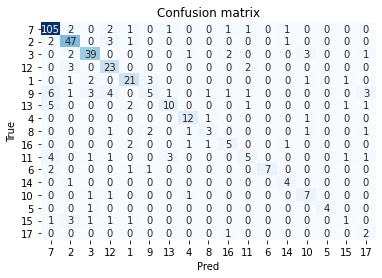

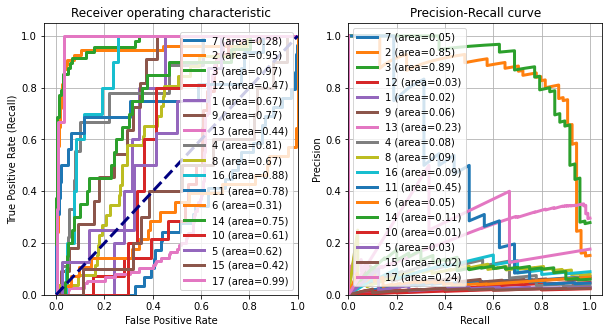

In [ ]:
errors, acc = evaluate_mode(X_test, model)

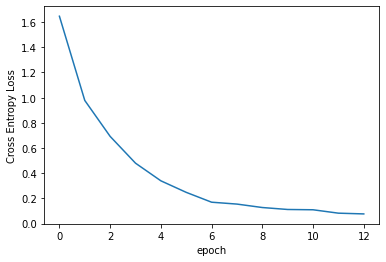

In [ ]:
## Plot loss for epoc

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(epoch+n_epochs-1), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
losses

[tensor(1.6467, device='cuda:0', requires_grad=True),
 tensor(0.9780, device='cuda:0', requires_grad=True),
 tensor(0.6925, device='cuda:0', requires_grad=True),
 tensor(0.4798, device='cuda:0', requires_grad=True),
 tensor(0.3397, device='cuda:0', requires_grad=True),
 tensor(0.2480, device='cuda:0', requires_grad=True),
 tensor(0.1699, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1549, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1276, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1121, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1097, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0828, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0768, device='cuda:0', grad_fn=<DivBackward0>)]

In [ ]:
# errors

In [ ]:
print(f"avg - {sum(accuracies[-10:])/len(accuracies[-10:])}")
accuracies

avg - 0.7217073170731707


[0.6585365853658537,
 0.7146341463414634,
 0.7268292682926829,
 0.7292682926829268,
 0.7439024390243902,
 0.7195121951219512,
 0.7195121951219512,
 0.7268292682926829,
 0.724390243902439,
 0.7146341463414634,
 0.7219512195121951,
 0.6853658536585366,
 0.7317073170731707]

In [ ]:
# save model configuration for latter training

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch+n_epochs,
    'losses': losses,
    'errors': errors,
    'accuracies': accuracies
}

torch.save(checkpoint, f"models/model_SDG_allrain_checkpoint_{checkpoint['epoch']}.tar")

# Top 7

##Predict Five Ps 

In [ ]:
def readDataAndselectTopGoals(N):
  data = read_data()
  labels = data['SDG Goal'].value_counts().index.tolist()[:N]
  return data[data['SDG Goal'].isin(labels)]

data = readDataAndselectTopGoals(7)
data.shape

(2119, 15)

In [ ]:
data['five Ps'].value_counts()

Prosperity    1121
People         856
Planet         142
Name: five Ps, dtype: int64

In [ ]:
data['Target'] = data['five Ps']
labels = list(data['Target'].value_counts().keys().values)
X_train, X_test, y_train, y_test = train_test_split(data, data["Target"], test_size=0.15, random_state=42)
print(labels)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.index[0:5])

['Prosperity', 'People', 'Planet']
1801 1801
318 318
Int64Index([2311, 1537, 67, 547, 1166], dtype='int64')


In [ ]:
X_train['Target'].value_counts()

Prosperity    955
People        727
Planet        119
Name: Target, dtype: int64

In [ ]:
X_test['Target'].value_counts()

Prosperity    166
People        129
Planet         23
Name: Target, dtype: int64

In [ ]:
# new model configuration

model = SDGModel(len(labels)).cuda()
optimizer = AdamW(model.parameters(), lr=1e-5)
losses = []
errors = []
accuracies = []
epoch = 1
model("Hello World")

tensor([ 0.0881, -0.0232, -0.0175], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
# # load model from checkpoint

# device = torch.device("cuda")
# model = SDGModel(len(labels))
# optimizer = AdamW(model.parameters(), lr=1e-5)

# checkpoint = torch.load(f"../models/model_5Ps_checkpoint_{12}.tar")
# model.load_state_dict(checkpoint['model_state_dict'])
# model.to(device)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']+1
# losses = checkpoint['losses']
# errors = checkpoint['errors']
# accuracies = checkpoint['accuracies']

# # model.eval()
# # - or -
# model.train()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

1801
Epoch=1, index=960, loss=0.45018984079360963, counter=13
People --> Prosperity
Epoch=1, index=150, loss=0.4810480574766795, counter=28
Prosperity --> Prosperity
Epoch=1, index=1350, loss=0.2791099230448405, counter=37
People --> Prosperity
Epoch=1, index=630, loss=1.6693573514620463, counter=93
Prosperity --> Prosperity
Epoch=1, index=540, loss=0.11161548296610514, counter=97
People --> People
Epoch=1, index=2640, loss=1.1022699226935704, counter=134
Prosperity --> Prosperity
Epoch=1, index=210, loss=0.7780900359153747, counter=166
Prosperity --> Prosperity
Epoch=1, index=270, loss=0.2664325589934985, counter=178
Prosperity --> Prosperity
Epoch=1, index=1950, loss=0.26786458094914756, counter=188
Prosperity --> People
Epoch=1, index=2400, loss=0.4703958615660667, counter=216
Prosperity --> Prosperity
Epoch=1, index=2190, loss=0.37303849558035534, counter=231
Prosperity --> Prosperity
Epoch=1, index=810, loss=1.0037306815385818, counter=264
Prosperity --> People
Epoch=1, index=2310

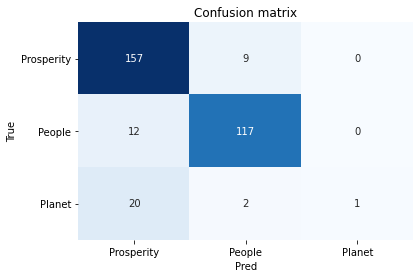

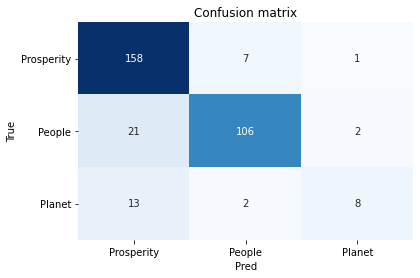

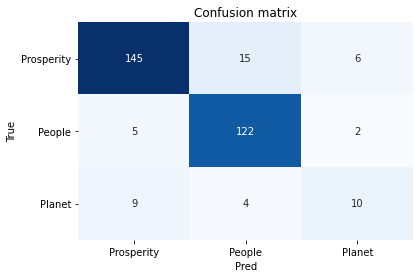

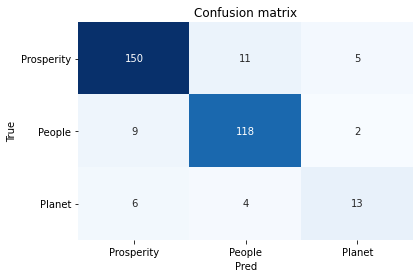

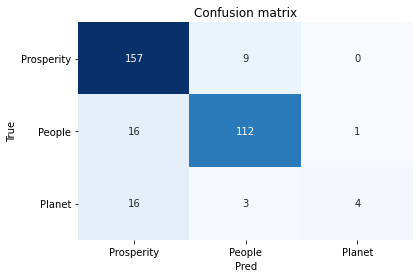

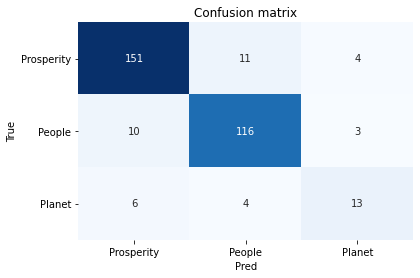

In [ ]:
import time

n_epochs = 6

start_time = time.time()

for e in range(epoch, epoch+n_epochs):
  cnt = 0
  current_loss = 0
  epoc_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    cnt += 1
    optimizer.zero_grad()
    out = model(instance["Description"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    epoc_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}, counter={cnt}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error, acc = evaluate_mode(X_test, model, False)
  print(error[0][:5])
  print(f"total loss={epoc_loss/len(curr_data)}")
  losses.append(epoc_loss/len(curr_data))
  errors.append(error)
  accuracies.append(acc)
  print(f"TIME TILL NOW: avg={(time.time() - start_time)/60/e:.1f}, for {e} epochs - {(time.time() - start_time)/60:.1f} min")

Accuracy: 0.88
Auc: 0.43
Detail:
              precision    recall  f1-score   support

      People       0.89      0.90      0.89       129
      Planet       0.65      0.57      0.60        23
  Prosperity       0.90      0.91      0.91       166

    accuracy                           0.88       318
   macro avg       0.81      0.79      0.80       318
weighted avg       0.88      0.88      0.88       318



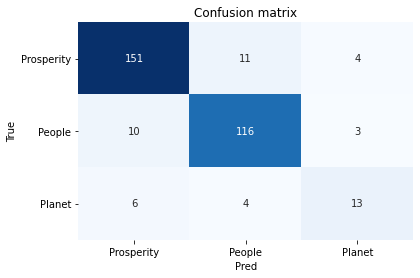

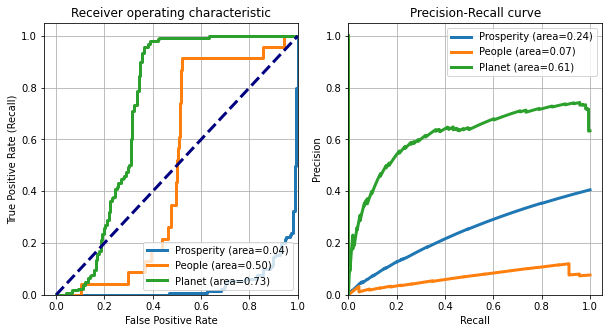

In [ ]:
errors, acc = evaluate_mode(X_test, model)

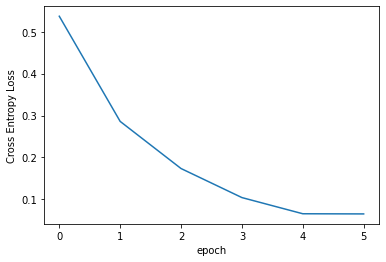

In [ ]:
## Plot loss for epoc

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(epoch+n_epochs-1), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
# errors

In [ ]:
print(f"avg - {sum(accuracies[-10:])/len(accuracies[-10:])}")
accuracies

avg - 0.868972746331237


[0.8647798742138365,
 0.8553459119496856,
 0.8710691823899371,
 0.8836477987421384,
 0.8584905660377359,
 0.8805031446540881]

In [ ]:
losses

[tensor(0.5370, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2859, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1734, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1041, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0655, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0651, device='cuda:0', grad_fn=<DivBackward0>)]

In [ ]:
# save model configuration for later training

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch+n_epochs,
    'losses': losses,
    'errors': errors,
    'accuracies': accuracies
}

torch.save(checkpoint, f"models/model_5Ps_allrain_top_7_checkpoint_{checkpoint['epoch']}.tar")

## Predict all goals

In [ ]:
def readDataAndselectTopGoals(N):
  data = read_data()
  labels = data['SDG Goal'].value_counts().index.tolist()[:N]
  return data[data['SDG Goal'].isin(labels)]

data = readDataAndselectTopGoals(7)
data.shape

(2119, 15)

In [ ]:
data['Target'] = data['SDG Goal'].astype(int)
labels = list(data['Target'].value_counts().keys().values)
X_train, X_test, y_train, y_test = train_test_split(data, data["Target"], test_size=0.15, random_state=42)
print(labels)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_train.index[0:5])

[7, 2, 3, 12, 1, 9, 13]
1801 1801
318 318
Int64Index([2311, 1537, 67, 547, 1166], dtype='int64')


In [ ]:
X_train['Target'].value_counts()

7     609
2     318
3     220
12    204
1     189
9     142
13    119
Name: Target, dtype: int64

In [ ]:
X_test['Target'].value_counts()

7     110
2      57
3      39
1      33
12     31
9      25
13     23
Name: Target, dtype: int64

In [ ]:
# # new model configuration

# model = SDGModel(len(labels)).cuda()
# optimizer = AdamW(model.parameters(), lr=1e-5)
# losses = []
# errors = []
# accuracies = []
# epoch = 1
# model("Hello World")

tensor([-1.4354e-03, -2.6473e-02, -9.0931e-02,  3.2414e-02, -2.7213e-01,
         3.2616e-02, -1.7866e-04], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
# load model from checkpoint

device = torch.device("cuda")
model = SDGModel(len(labels))
optimizer = AdamW(model.parameters(), lr=1e-5)

checkpoint = torch.load(f"models/model_SDG__allrain_top_7_checkpoint_7.tar")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
losses = checkpoint['losses']
errors = checkpoint['errors']
accuracies = checkpoint['accuracies']

model.eval()
# - or -
# model.train()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

1801
Epoch=1, index=1200, loss=3.4910862882932028, counter=55
2.0 --> 7.0
Epoch=1, index=1380, loss=0.6923009514808655, counter=66
9.0 --> 7.0
Epoch=1, index=1980, loss=0.6778215289115905, counter=77
3.0 --> 7.0
Epoch=1, index=1500, loss=0.5608160416285197, counter=86
7.0 --> 2.0
Epoch=1, index=30, loss=1.4846090078353882, counter=111
7.0 --> 7.0
Epoch=1, index=870, loss=2.9886852939923605, counter=167
3.0 --> 2.0
Epoch=1, index=900, loss=0.06691944599151611, counter=168
3.0 --> 2.0
Epoch=1, index=540, loss=1.5255570530891418, counter=197
3.0 --> 2.0
Epoch=1, index=2010, loss=0.5183979233105978, counter=206
9.0 --> 7.0
Epoch=1, index=1710, loss=2.425286049644152, counter=260
2.0 --> 2.0
Epoch=1, index=1290, loss=0.5329109887282054, counter=272
7.0 --> 7.0
Epoch=1, index=2670, loss=1.8498860458532969, counter=309
12.0 --> 7.0
Epoch=1, index=1140, loss=2.5929383864005406, counter=381
2.0 --> 2.0
Epoch=1, index=2160, loss=0.005844184259573618, counter=382
7.0 --> 7.0
Epoch=1, index=2280, 

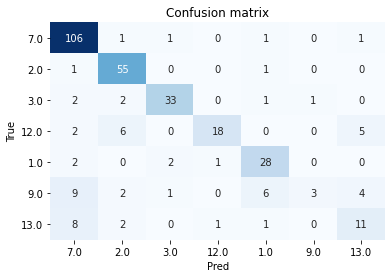

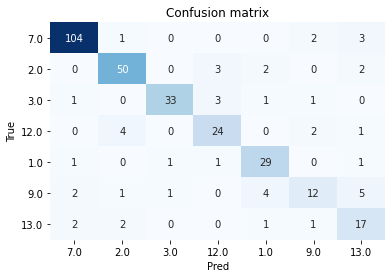

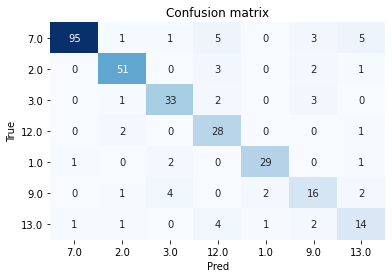

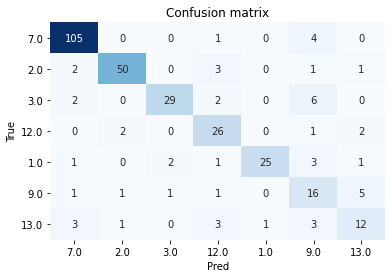

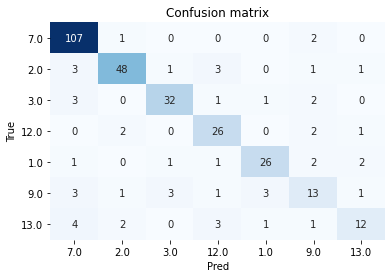

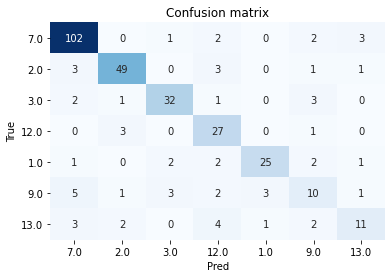

In [ ]:
import time

n_epochs = 6

start_time = time.time()

for e in range(epoch, epoch+n_epochs):
  cnt = 0
  current_loss = 0
  epoc_loss = 0;
  curr_data = X_train.sample(frac=1)
  print(len(curr_data))
  for index, instance in curr_data.iterrows():
    cnt += 1
    optimizer.zero_grad()
    out = model(instance["Description"].lower())
    loss = criterion(out.view(1, -1), torch.LongTensor([labels.index(instance["Target"])]).cuda())
    epoc_loss += loss
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    if index % 30 == 0:
      print(f"Epoch={e}, index={index}, loss={current_loss/30}, counter={cnt}")
      print(f"{instance['Target']} --> {labels[torch.argmax(out).item()]}")
      current_loss = 0
  error, acc = evaluate_mode(X_test, model, False)
  print(error[0][:5])
  print(f"total loss={epoc_loss/len(curr_data)}")
  losses.append(epoc_loss/len(curr_data))
  errors.append(error)
  accuracies.append(acc)
  print(f"TIME TILL NOW: avg={(time.time() - start_time)/60/e:.1f}, for {e} epochs - {(time.time() - start_time)/60:.1f} min")

Accuracy: 0.81
Auc: 0.65
Detail:
              precision    recall  f1-score   support

           1       0.86      0.76      0.81        33
           2       0.88      0.86      0.87        57
           3       0.84      0.82      0.83        39
           7       0.88      0.93      0.90       110
           9       0.48      0.40      0.43        25
          12       0.66      0.87      0.75        31
          13       0.65      0.48      0.55        23

    accuracy                           0.81       318
   macro avg       0.75      0.73      0.73       318
weighted avg       0.80      0.81      0.80       318



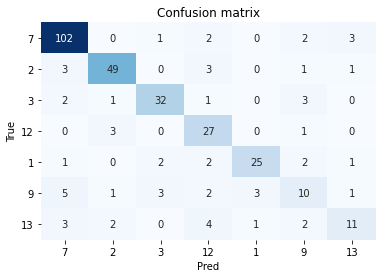

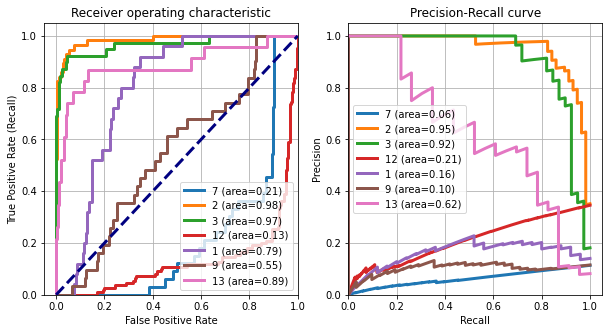

In [ ]:
errors, acc = evaluate_mode(X_test, model)

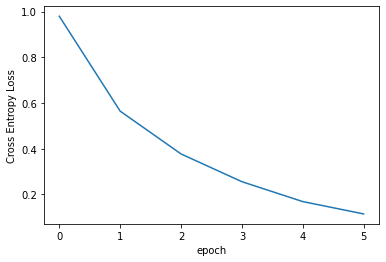

In [ ]:
## Plot loss for epoc

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(epoch+n_epochs-1), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [ ]:
losses

[tensor(0.9799, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.5644, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3770, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2555, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1684, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1144, device='cuda:0', grad_fn=<DivBackward0>)]

In [ ]:
# errors

In [ ]:
print(f"avg - {sum(accuracies[-10:])/len(accuracies[-10:])}")
accuracies

avg - 0.8238993710691824


[0.7987421383647799,
 0.8459119496855346,
 0.8364779874213837,
 0.8270440251572327,
 0.8301886792452831,
 0.8050314465408805]

In [ ]:
# save model configuration for latter training

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch+n_epochs,
    'losses': losses,
    'errors': errors,
    'accuracies': accuracies
}

torch.save(checkpoint, f"models/model_SDG__allrain_top_7_checkpoint_{checkpoint['epoch']}.tar")